In [40]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegressionCV


In [41]:
bp = pd.read_csv('../processed_data/bp_data.csv')
bp.shape

(514, 14)

In [42]:
ed = pd.read_csv('../processed_data/ed_data.csv')
ed.shape

(514, 52)

In [43]:
geo = pd.read_csv('../processed_data/geo_data.csv')
geo.shape

(514, 76)

In [44]:
lab = pd.read_csv('../processed_data/lab_data.csv')
lab.shape

(514, 26)

In [45]:
visit = pd.read_csv('../processed_data/visit_data.csv')
visit.shape

(514, 6)

In [46]:
mergecolumns = ['encrypt_mrn', 'ed_screened', 'visit_date', 'new_diagnosis', 'pcp_followup']

data = pd.merge(bp, ed, on=mergecolumns, how='left')
data = pd.merge(data, geo, on=mergecolumns, how='left')
data = pd.merge(data, lab, on=mergecolumns, how='left')
data = pd.merge(data, visit, on=mergecolumns, how='left')


In [47]:
data.shape

(514, 154)

In [48]:
data = data[data['new_diagnosis'] == 'Yes']
data.shape

(257, 154)

In [49]:
# follow up in data
data['pcp_followup'].value_counts()


pcp_followup
Yes    204
No      50
Name: count, dtype: int64

In [50]:
# follow up null 
data['pcp_followup'].isnull().sum()

np.int64(3)

In [51]:
# drop null
data = data.dropna(subset=['pcp_followup'])
data.shape

(254, 154)

In [52]:
data.to_csv('../processed_data/merged_data.csv', index=False)

In [53]:
list_bp = ['avg_dbp', 'avg_diff', 'avg_sbp', 'max_sbp']

In [54]:
list_ed = ['age', 'sex', 'detailed_race', 'language', 'insurance_type', 
            'bmi', 'height', 'weight', 'dm_on_pl', 'dm_on_pmh', 'htn_on_pl', 'htn_on_pmh',         'hld_on_pl', 'hld_on_pmh',
            'gdm_on_pl', 'gdm_on_pmh', 'pcos_on_pl', 'pcos_on_pmh', 'cad_on_pl', 'cad_on_pmh',
            'chf_on_pl', 'chf_on_pmh',
            'depression_on_pl', 'depression_on_pmh', 'cva_on_pl', 'cva_on_pmh', 'family_dm', 'tobacco_user', 'dm_meds', 'htn_meds', 'statin_meds', 'aspirin_meds', 'plavix_meds','lasix_meds', 'disposition',
            'ed_name', 'sbp_1st', 'dbp_1st', 'bpa_response', 'primary_care', 'hba1c', 'poct_gluc', 'chem_gluc',
            'chem_creat']

In [55]:
list_lab = [ 'avg_value_CHOLESTEROL, TOTAL', 'avg_value_CREATININE', 'avg_value_GLUCOSE', 'avg_value_GLUCOSE, POC', 'avg_value_HDL CHOLESTEROL', 'avg_value_HEMOGLOBIN A1C', 'avg_value_LDL CHOLESTEROL, CALCULATED']

In [56]:
list_geo = []

In [57]:
list_visit = ['visit_type']

In [58]:
lists = list_bp + list_ed + list_lab + list_geo + list_visit
X_all = data[lists]
y = data['pcp_followup'].map({'Yes': 1, 'No': 0}).astype(int).values

In [59]:
numeric_cols = X_all.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_all.select_dtypes(exclude=['number']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, 
    test_size=0.2, 
    random_state=50,
    stratify=y
)



In [61]:
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

num_feature_names = np.array(numeric_cols)  
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

X_train_num = X_train_preprocessed[:, :len(num_feature_names)]
X_train_cat = X_train_preprocessed[:, len(num_feature_names):]
X_test_num = X_test_preprocessed[:, :len(num_feature_names)]
X_test_cat = X_test_preprocessed[:, len(num_feature_names):]

In [62]:
scorer = make_scorer(f1_score, average='binary', pos_label=1)
logisticcv = LogisticRegressionCV(
    Cs=[1e-5, 1e-3, 1e-1, 1],  
    cv=LeaveOneOut(),
    penalty='l1',
    solver='liblinear', 
    max_iter=100000,
    tol=1e-10,
    scoring=scorer,
    random_state=50,
    fit_intercept=True,
    refit=True,
    n_jobs=-1,
    class_weight=None,
)

In [63]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
smote = SMOTE(random_state=50)
adasyn = ADASYN(random_state=50)
X_train_num, y_train_num = adasyn.fit_resample(X_train_num, y_train)

In [64]:
logisticcv.fit(X_train_num, y_train_num)
print(f"optimal C for numeric features: {logisticcv.C_[0]}")
num_coef = logisticcv.coef_[0]
num_importance = pd.DataFrame({
    'feature': [name.replace('num__', '') for name in num_feature_names],
    'importance': num_coef
}).sort_values('importance', ascending=False)

optimal C for numeric features: 1.0


In [65]:
num_importance

,feature,importance
14,chem_creat,0.940810
12,poct_gluc,0.843998
7,weight,0.727851
10,dbp_1st,0.467662
17,avg_value_GLUCOSE,0.411014
15,"avg_value_CHOLESTEROL, TOTAL",0.387050
4,age,0.375640
3,max_sbp,0.260560
21,"avg_value_LDL CHOLESTEROL, CALCULATED",0.244817
1,avg_diff,0.074320


In [ ]:
# save num_importance
num_importance.to_csv('../processed_data/num_importance_2.csv', index=False)

In [67]:
print(num_importance.head(10))

                                  feature  importance
14                             chem_creat    0.940810
12                              poct_gluc    0.843998
7                                  weight    0.727851
10                                dbp_1st    0.467662
17                      avg_value_GLUCOSE    0.411014
15           avg_value_CHOLESTEROL, TOTAL    0.387050
4                                     age    0.375640
3                                 max_sbp    0.260560
21  avg_value_LDL CHOLESTEROL, CALCULATED    0.244817
1                                avg_diff    0.074320


In [68]:
print(num_importance.tail(10))

                      feature  importance
2                     avg_sbp    0.000000
9                     sbp_1st   -0.135361
0                     avg_dbp   -0.185455
6                      height   -0.250714
11                      hba1c   -0.262350
5                         bmi   -0.287271
13                  chem_gluc   -0.312544
19  avg_value_HDL CHOLESTEROL   -0.338276
18     avg_value_GLUCOSE, POC   -0.733658
16       avg_value_CREATININE   -1.092150


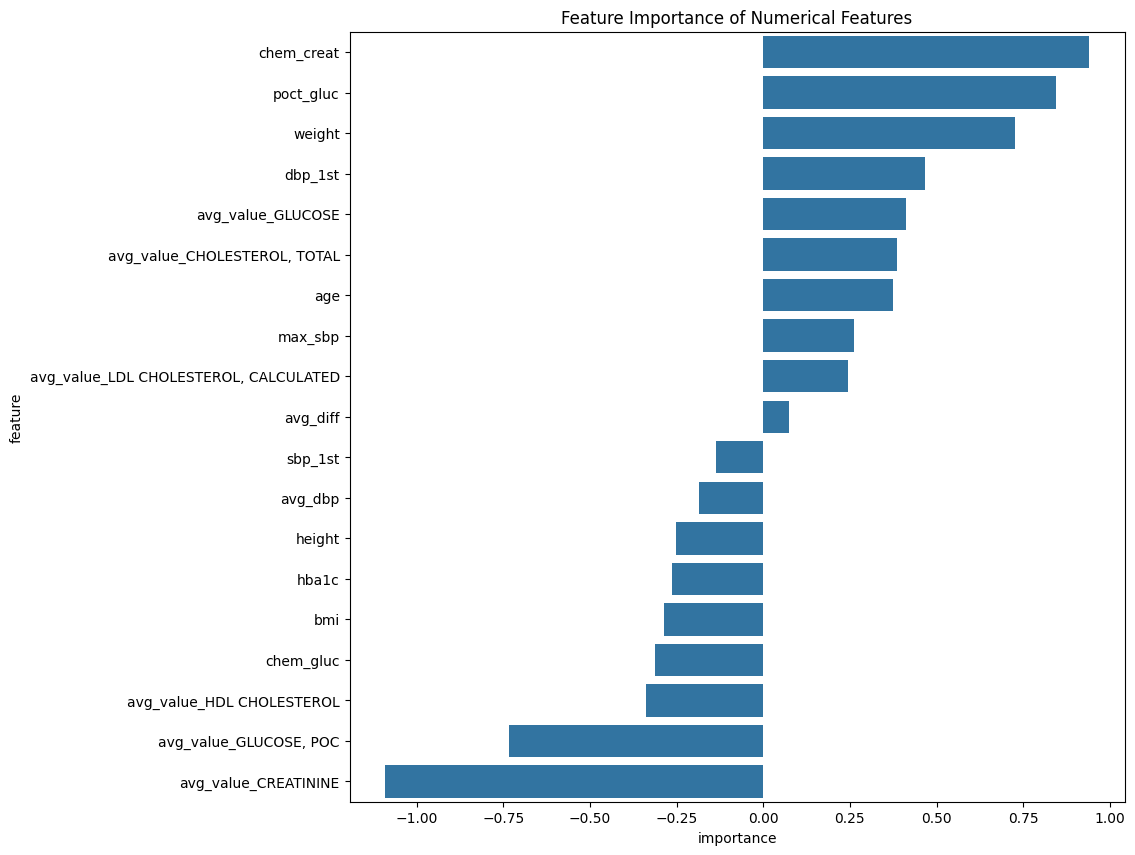

In [69]:
pos = num_importance[num_importance['importance'] > 0].head(10)
neg = num_importance[num_importance['importance'] < 0].tail(10)
num_features = pd.concat([pos, neg])
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=num_features)
plt.title('Feature Importance of Numerical Features')
plt.show()

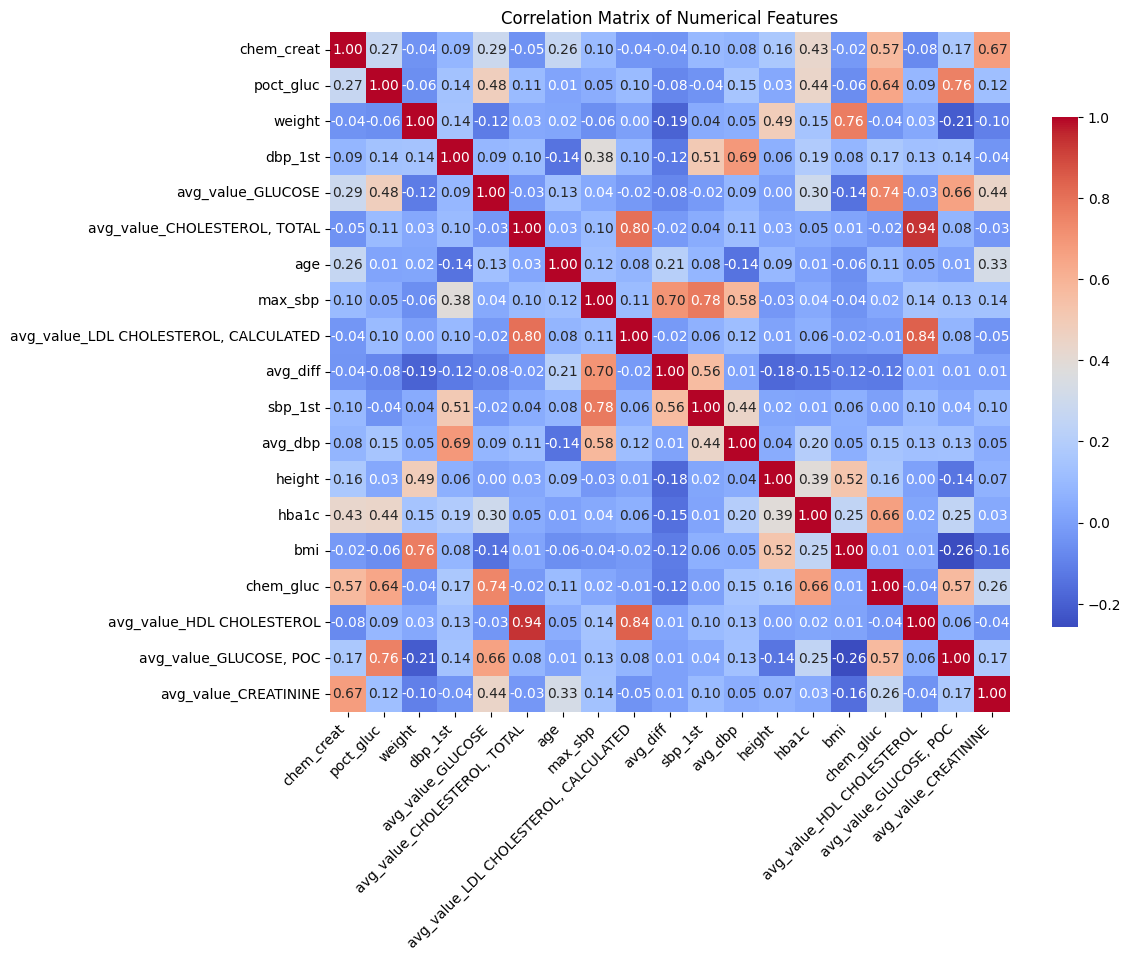

In [70]:
X_train_num_df = pd.DataFrame(X_train_num, columns=num_feature_names)
selected_num_feature_names = num_features['feature'].tolist()
X_train_num_df = pd.DataFrame(X_train_num, columns=num_feature_names)
X_train_num_df = X_train_num_df[selected_num_feature_names]
corr_matrix = X_train_num_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar=True,
    annot_kws={"size": 10},
    cbar_kws={
        "shrink": 0.5,      
        "aspect": 20,        
    }
)
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [71]:
X_train_cat, y_train_cat = adasyn.fit_resample(X_train_cat, y_train)

In [72]:
logisticcv.fit(X_train_cat, y_train_cat)
print(f"optimal C for categorical features: {logisticcv.C_[0]}")

cat_coef = logisticcv.coef_[0]
cat_importance = pd.DataFrame({
    'feature': [name.replace('cat__', '') for name in cat_feature_names],
    'importance': cat_coef
}).sort_values('importance', ascending=False)

optimal C for categorical features: 1.0


In [73]:
cat_importance

,feature,importance
40,depression_on_pl_Yes,2.266541
75,ed_name_NYU COBBLE HILL,2.056707
24,hld_on_pl_Yes,1.237329
45,cva_on_pmh_Yes,1.226086
67,lasix_meds_Yes,0.917086
...,...,...
71,disposition_Discharge,-0.849469
3,detailed_race_Black,-0.858644
73,disposition_Transfer to Procedure Area,-0.963506
14,insurance_type_SELFPAY,-1.037418


In [ ]:
# save cat_importance
cat_importance.to_csv('../processed_data/cat_importance_2.csv', index=False)

In [75]:
print(cat_importance.head(10))

                    feature  importance
40     depression_on_pl_Yes    2.266541
75  ed_name_NYU COBBLE HILL    2.056707
24            hld_on_pl_Yes    1.237329
45           cva_on_pmh_Yes    1.226086
67           lasix_meds_Yes    0.917086
52              dm_meds_Yes    0.904426
22           htn_on_pmh_Yes    0.821310
58          statin_meds_Yes    0.799473
81          primary_care_NO    0.793545
13   insurance_type_PRIVATE    0.580695


In [76]:
print(cat_importance.tail(10))

                                   feature  importance
23                            hld_on_pl_No   -0.258553
74                    ed_name_NYU BROOKLYN   -0.401537
18                           dm_on_pmh_Yes   -0.631623
38                          chf_on_pmh_Yes   -0.708792
82                        primary_care_YES   -0.769917
71                   disposition_Discharge   -0.849469
3                      detailed_race_Black   -0.858644
73  disposition_Transfer to Procedure Area   -0.963506
14                  insurance_type_SELFPAY   -1.037418
10                 insurance_type_MEDICAID   -1.197378


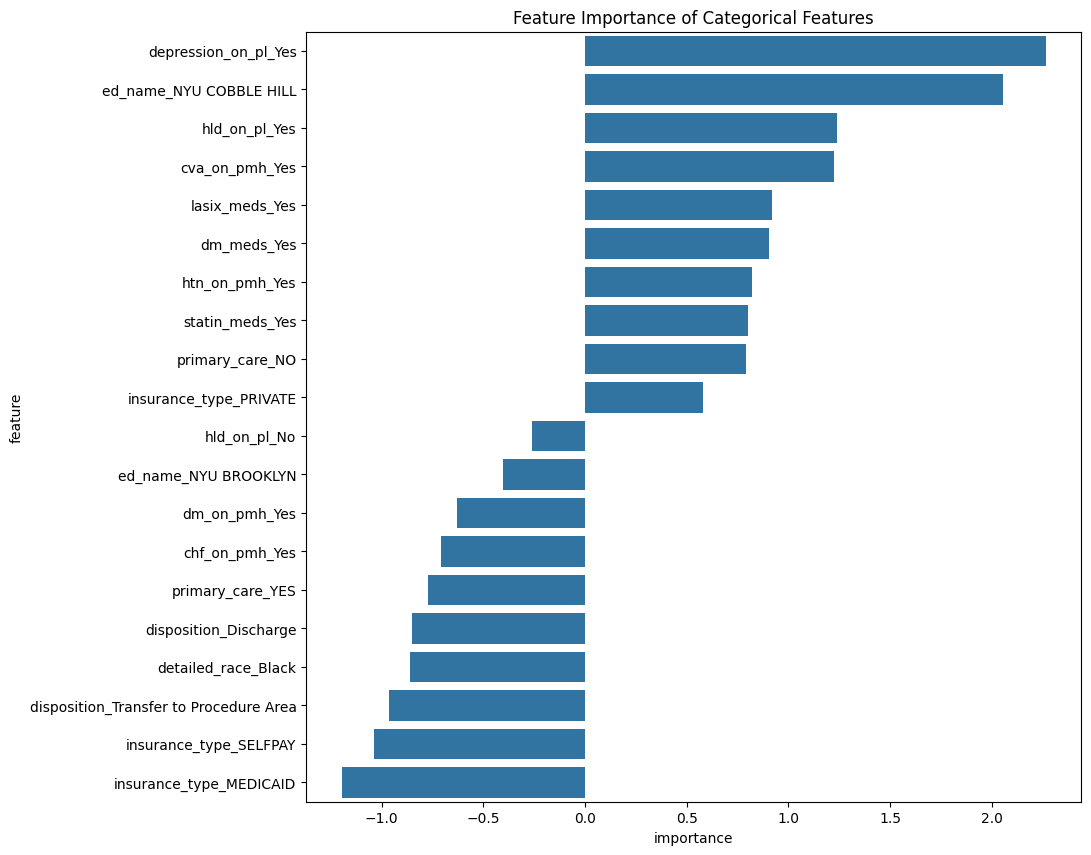

In [77]:
pos = cat_importance[cat_importance['importance'] > 0].head(10)
neg = cat_importance[cat_importance['importance'] < 0].tail(10)
cat_features = pd.concat([pos, neg])
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=cat_features)
plt.title('Feature Importance of Categorical Features')
plt.show()

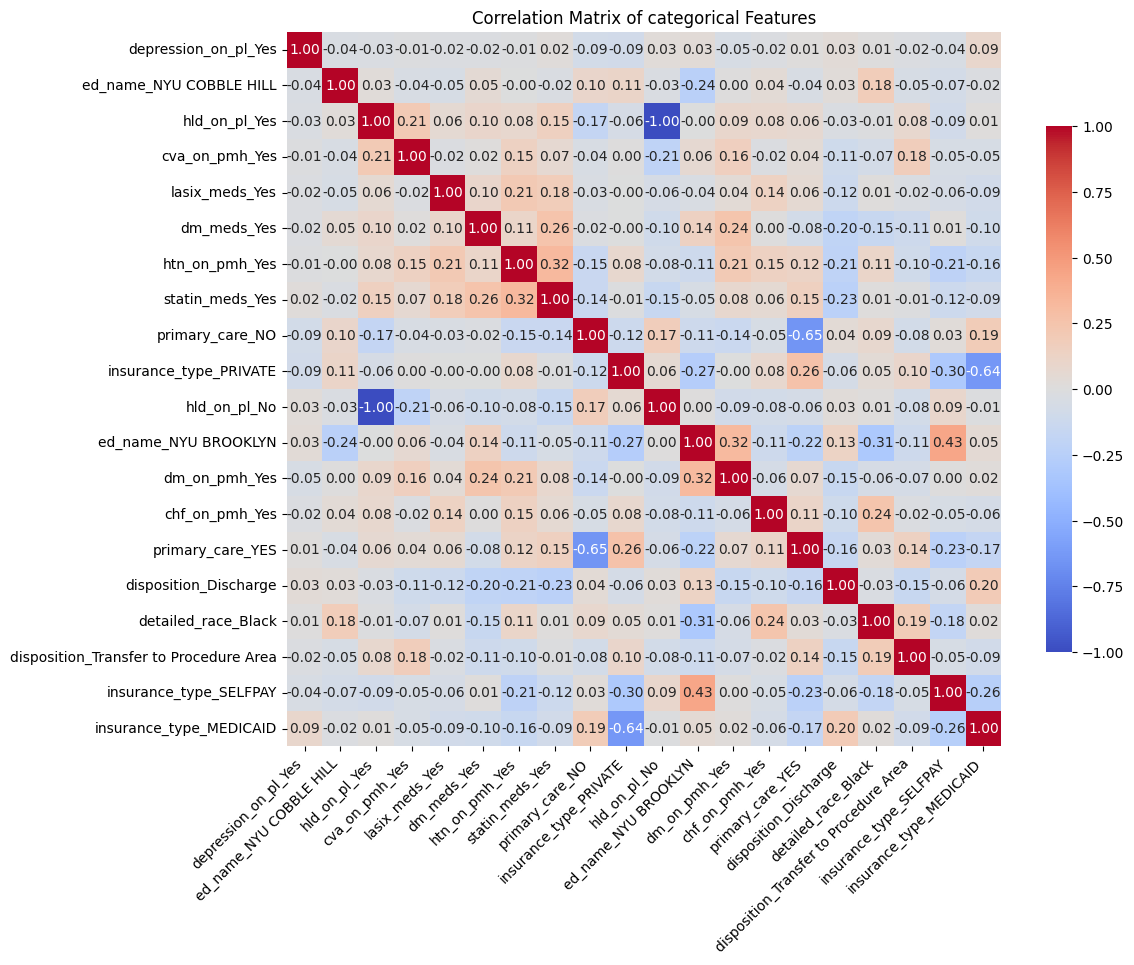

In [78]:
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names)
selected_cat_feature_names = cat_features['feature'].tolist()
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names)
X_train_cat_df = X_train_cat_df[selected_cat_feature_names]
corr_matrix = X_train_cat_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar=True,
    annot_kws={"size": 10},
    cbar_kws={
        "shrink": 0.5,      
        "aspect": 20,        
    }
)
plt.title("Correlation Matrix of categorical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced',],
}

rf_model = RandomForestClassifier(random_state=50)

scorer = make_scorer(f1_score, average='weighted')


grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=50,                       
    scoring=scorer,        
    verbose=1,
    n_jobs= -1
)


In [ ]:
X = data[lists]
y = data['pcp_followup'].map({'Yes': 1, 'No': 0})
y = np.array(y).astype(int)

categorical_columns = X.select_dtypes(include=['object']).columns
X_categorical = X[categorical_columns]
X_encoded = pd.get_dummies(X_categorical, drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=50)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_model

Fitting 50 folds for each of 3600 candidates, totalling 180000 fits


RandomForestClassifier(class_weight='balanced', max_depth=4,
                       max_features='log2', min_samples_split=3,
                       random_state=50)

                                      Feature  Importance
8                      insurance_type_PRIVATE    0.101590
31                               htn_meds_Yes    0.072422
5                     insurance_type_MEDICAID    0.058037
35                          disposition_Admit    0.053842
36                      disposition_Discharge    0.053631
13                    ed_name_NYU COBBLE HILL    0.047696
33                            statin_meds_Yes    0.044167
12                       ed_name_NYU BROOKLYN    0.041624
4                            language_Spanish    0.035816
20                              htn_on_pmh_No    0.033566
2                            language_English    0.027827
21                             htn_on_pmh_Yes    0.027149
29                           tobacco_user_Yes    0.022556
10                            primary_care_NO    0.020334
17                  bpa_response_Single Order    0.020279
0                                  sex_Female    0.019788
30            

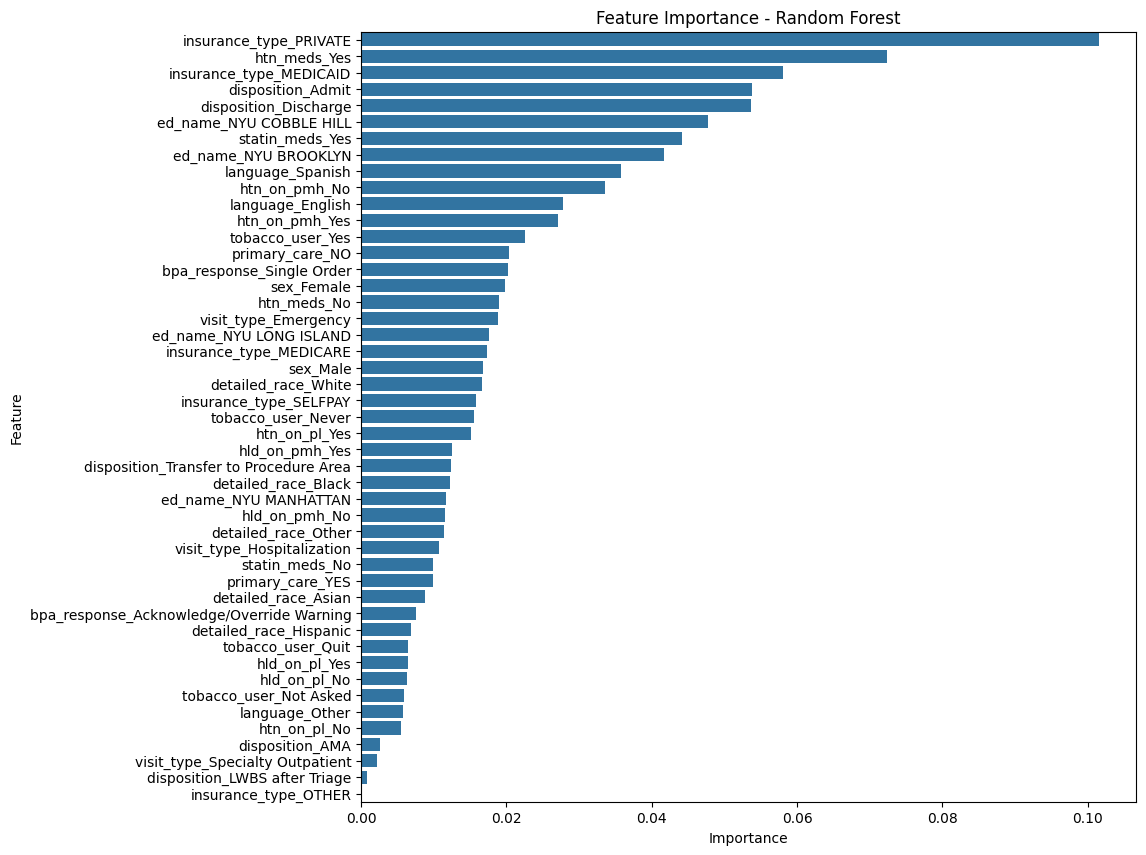

In [ ]:
importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df

print(feature_importance_df)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importance - Random Forest')
plt.show()

In [ ]:
X = data[lists].select_dtypes(include=['number'])
y = data['pcp_followup'].map({'Yes': 1, 'No': 0})
y = np.array(y).astype(int)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_model

Fitting 50 folds for each of 3600 candidates, totalling 180000 fits


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features='log2', min_samples_leaf=3,
                       n_estimators=50, random_state=50)

                      Feature  Importance
0                     avg_dbp    0.049966
42              p_cohabitkids    0.045558
10                    sbp_1st    0.036678
33                  p_nhasian    0.036266
44                   p_hsonly    0.036175
..                        ...         ...
22                  total_pop    0.000000
17  avg_value_HDL CHOLESTEROL    0.000000
21                   homeless    0.000000
48           p_spanishlimited    0.000000
64                   h_renter    0.000000

[79 rows x 2 columns]


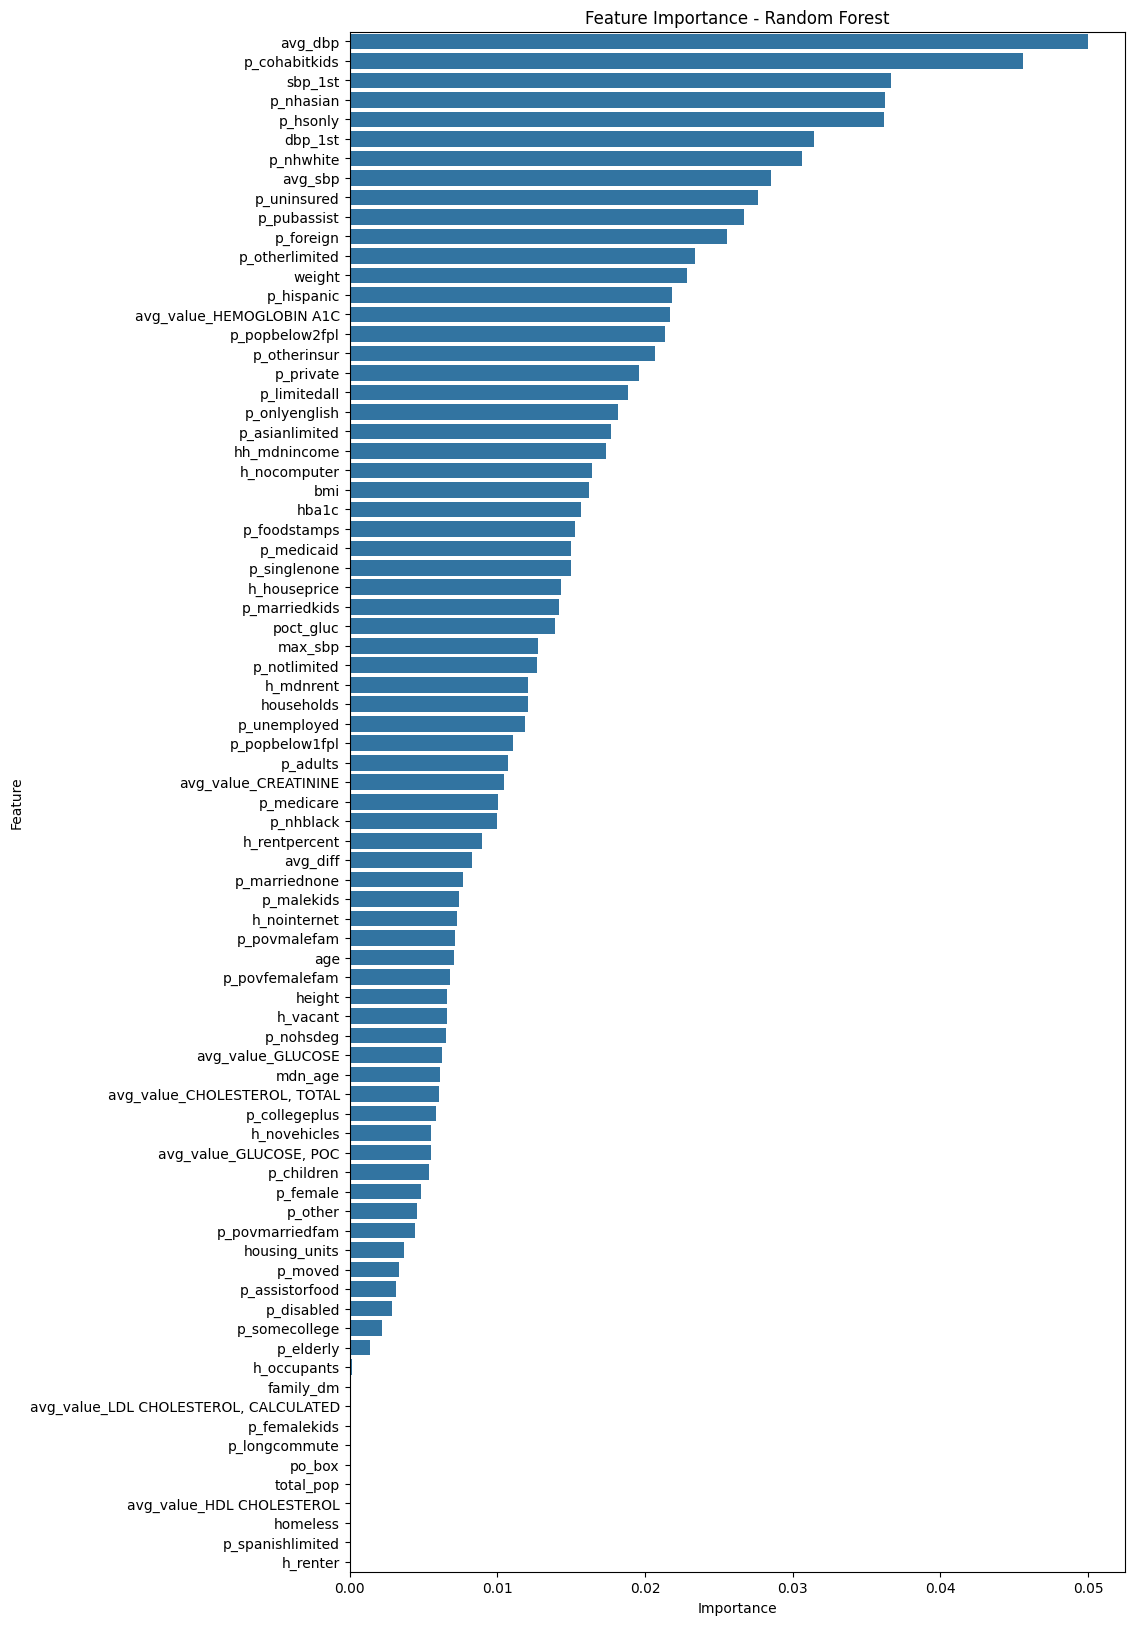

In [ ]:
importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - Random Forest')
plt.show()
